In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%pip install torch pyro-ppl scikit-learn seaborn -q

In [7]:
df = pd.read_csv('NanoTox _unidas.csv')

display(df.head())
display(df.describe())
display(df.info())

,NPs,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class
0,Al2O3,267.0,36.3,64.7,-1.51,24.0,0.001,1.61,3.0,0.0
1,Al2O3,267.0,36.3,64.7,-1.51,24.0,0.010,1.61,3.0,0.0
2,Al2O3,267.0,36.3,64.7,-1.51,24.0,0.100,1.61,3.0,0.0
3,Al2O3,267.0,36.3,64.7,-1.51,24.0,1.000,1.61,3.0,0.0
4,Al2O3,267.0,36.3,64.7,-1.51,24.0,5.000,1.61,3.0,0.0


,hydrosize,surfcharge,surfarea,Ec,Expotime,dosage,e,NOxygen,class
count,1363.000000,1363.000000,1363.000000,1363.000000,1363.000000,1363.000000,1363.000000,1363.000000,1363.000000
mean,220.403448,0.048423,46.777021,-4.013191,26.117388,37.742507,1.636889,1.393984,0.406456
std,323.285979,25.010010,51.341579,0.531168,19.347339,40.477966,0.089429,0.585828,0.491352
min,7.500000,-41.600000,7.000000,-5.170000,3.000000,0.000010,1.540000,1.000000,0.000000
25%,35.600000,-11.700000,20.000000,-4.160000,12.000000,6.250000,1.540000,1.000000,0.000000
50%,100.000000,-10.000000,27.900000,-3.890000,24.000000,25.000000,1.650000,1.000000,0.000000
75%,273.400000,27.400000,50.000000,-3.890000,24.000000,50.000000,1.650000,2.000000,1.000000
max,1843.000000,42.800000,210.000000,-1.510000,72.000000,300.000000,1.900000,3.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NPs         1363 non-null   object 
 1   hydrosize   1363 non-null   float64
 2   surfcharge  1363 non-null   float64
 3   surfarea    1363 non-null   float64
 4   Ec          1363 non-null   float64
 5   Expotime    1363 non-null   float64
 6   dosage      1363 non-null   float64
 7   e           1363 non-null   float64
 8   NOxygen     1363 non-null   float64
 9   class       1363 non-null   float64
dtypes: float64(9), object(1)
memory usage: 115.9+ KB


None

In [10]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")

# Preparar datos
df_clean = df.dropna()
X = df_clean.drop(['NPs', 'class'], axis=1).values
y = df_clean['class'].values

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\n📊 Datos preparados:")
print(f"  Entrenamiento: {X_train_tensor.shape}")
print(f"  Prueba: {X_test_tensor.shape}")
print(f"  Clases (train): {torch.bincount(y_train_tensor.long())}")


c:\Users\DaVas\miniconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando device: cpu

📊 Datos preparados:
  Entrenamiento: torch.Size([1090, 8])
  Prueba: torch.Size([273, 8])
  Clases (train): tensor([647, 443])


In [13]:
# Definir Red Neuronal Bayesiana con Pyro (arquitectura corregida)
from pyro.infer.autoguide import AutoDelta

class BayesianNN(PyroModule):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Capa 1: Pesos bayesianos (sin usar PyroSample)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc1_w_loc = PyroSample(dist.Normal(0, 1).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1_b_loc = PyroSample(dist.Normal(0, 1).expand([hidden_dim]).to_event(1))
        
        # Capa 2: Pesos bayesianos
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.fc2_w_loc = PyroSample(dist.Normal(0, 1).expand([1, hidden_dim]).to_event(2))
        self.fc2_b_loc = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))
        
    def forward(self, x):
        # Usar capas estándar (no PyroModule[nn.Linear])
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Modelo para Pyro
def model(X, y):
    # Muestrear pesos bayesianos
    fc1_w = pyro.sample("fc1_w", dist.Normal(0, 1).expand([64, X.shape[1]]).to_event(2))
    fc1_b = pyro.sample("fc1_b", dist.Normal(0, 1).expand([64]).to_event(1))
    fc2_w = pyro.sample("fc2_w", dist.Normal(0, 1).expand([1, 64]).to_event(2))
    fc2_b = pyro.sample("fc2_b", dist.Normal(0, 1).expand([1]).to_event(1))
    
    # Forward pass con pesos bayesianos
    with pyro.plate("data", len(X)):
        h = torch.relu(torch.matmul(X, fc1_w.t()) + fc1_b)
        logits = torch.sigmoid(torch.matmul(h, fc2_w.t()) + fc2_b).squeeze(-1)
        # Verosimilitud
        pyro.sample("obs", dist.Bernoulli(logits), obs=y)

# Crear guía automática
def guide(X, y):
    pass  # AutoDelta lo manejará

# Crear modelo
pyro.clear_param_store()

print("✅ Red Neuronal Bayesiana definida (arquitectura corregida)")
print(f"   Capas: {X_train_tensor.shape[1]} → 64 → 1")
print(f"   Device: {device}")


✅ Red Neuronal Bayesiana definida (arquitectura corregida)
   Capas: 8 → 64 → 1
   Device: cpu


In [14]:
# Entrenar la Red Neuronal Bayesiana con AutoDelta
print("🚀 Iniciando entrenamiento con AutoDelta guide...\n")

pyro.clear_param_store()

# Crear guía automática
guide_auto = AutoDelta(model)

# Crear optimizador
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# SVI (Stochastic Variational Inference)
svi = SVI(model, guide_auto, optimizer, loss=Trace_ELBO())

# Parámetros de entrenamiento
num_epochs = 150
batch_size = 64

losses = []

for epoch in range(num_epochs):
    # Barajar datos
    indices = torch.randperm(len(X_train_tensor))
    X_train_shuffled = X_train_tensor[indices]
    y_train_shuffled = y_train_tensor[indices]
    
    epoch_loss = 0
    num_batches = 0
    
    for i in range(0, len(X_train_shuffled), batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        
        loss = svi.step(X_batch, y_batch)
        epoch_loss += loss
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 30 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} - Loss: {avg_loss:.4f}")

print("\n✅ Entrenamiento completado exitosamente")


🚀 Iniciando entrenamiento con AutoDelta guide...

Epoch  30/150 - Loss: 609.4229
Epoch  60/150 - Loss: 609.6856
Epoch  90/150 - Loss: 609.4261
Epoch 120/150 - Loss: 609.4471
Epoch 150/150 - Loss: 609.5032

✅ Entrenamiento completado exitosamente


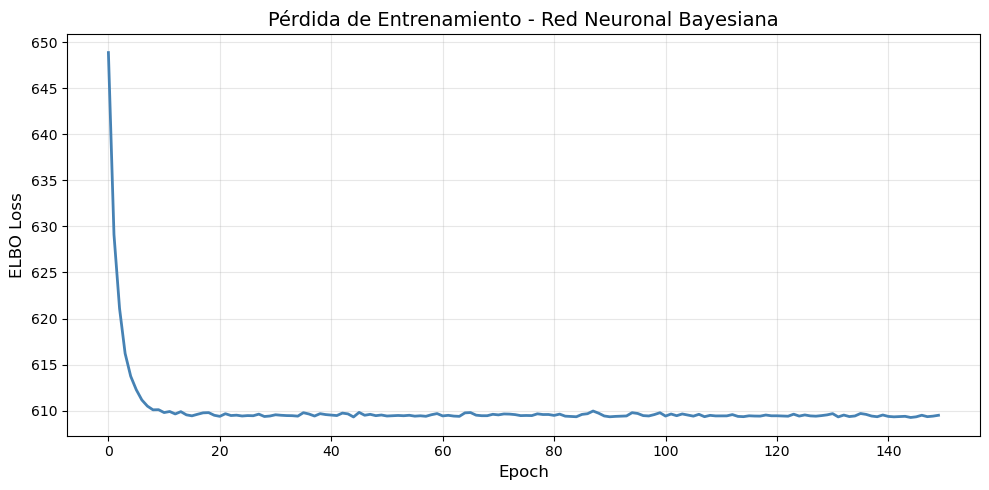

Pérdida inicial: 648.8686
Pérdida final: 609.5032


In [16]:
# Visualizar pérdida de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2, color='steelblue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ELBO Loss', fontsize=12)
plt.title('Pérdida de Entrenamiento - Red Neuronal Bayesiana', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Pérdida inicial: {losses[0]:.4f}")
print(f"Pérdida final: {losses[-1]:.4f}")


In [17]:
# Evaluación en datos de prueba
print("📈 Evaluando en datos de prueba...\n")

# Obtener pesos aprendidos
fc1_w_mean = guide_auto.median()["fc1_w"]
fc1_b_mean = guide_auto.median()["fc1_b"]
fc2_w_mean = guide_auto.median()["fc2_w"]
fc2_b_mean = guide_auto.median()["fc2_b"]

# Realizar predicciones con pesos posteriores medios
with torch.no_grad():
    h_test = torch.relu(torch.matmul(X_test_tensor, fc1_w_mean.t()) + fc1_b_mean)
    y_pred_proba = torch.sigmoid(torch.matmul(h_test, fc2_w_mean.t()) + fc2_b_mean).squeeze(-1)
    y_pred_proba_np = y_pred_proba.cpu().numpy()
    y_pred = (y_pred_proba_np >= 0.5).astype(int)
    y_test_np = y_test_tensor.cpu().numpy().astype(int)

# Métricas
print("Reporte de Clasificación:")
print("=" * 50)
print(classification_report(y_test_np, y_pred, target_names=['No Tóxico', 'Tóxico']))

# Matriz de confusión
cm = confusion_matrix(y_test_np, y_pred)
print("\nMatriz de Confusión:")
print(cm)

# ROC-AUC
roc_auc = roc_auc_score(y_test_np, y_pred_proba_np)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


📈 Evaluando en datos de prueba...

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.91      0.89      0.90       162
      Tóxico       0.84      0.87      0.86       111

    accuracy                           0.88       273
   macro avg       0.88      0.88      0.88       273
weighted avg       0.88      0.88      0.88       273


Matriz de Confusión:
[[144  18]
 [ 14  97]]

ROC-AUC Score: 0.9607


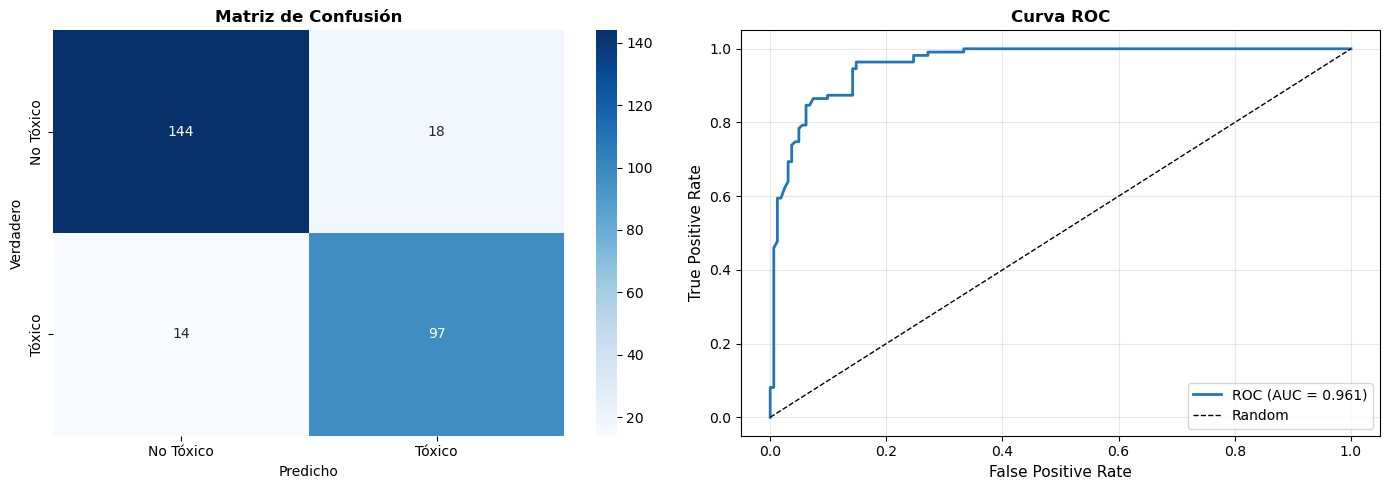

In [21]:
import seaborn as sns

# Visualizar matriz de confusión y ROC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Tóxico', 'Tóxico'], 
            yticklabels=['No Tóxico', 'Tóxico'])
axes[0].set_title('Matriz de Confusión', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Verdadero')
axes[0].set_xlabel('Predicho')

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('Curva ROC', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Voy a darte una explicación completa y detallada de todo el proyecto:

---

## 🧠 **GUÍA COMPLETA: RED NEURONAL BAYESIANA PARA TOXICIDAD DE NANOPARTÍCULAS**

### **📍 PARTE 0: EL PROBLEMA (¿POR QUÉ ESTO?)**

Tu dataset contiene **1,363 nanopartículas** con 8 características (hydrosize, surfcharge, surfarea, Ec, Expotime, dosage, e, NOxygen) y necesitas **predecir si son tóxicas o no**.

El problema es que **predicciones normales son insuficientes**. Necesitas:
- ✅ Saber si el modelo está **seguro** de su predicción
- ✅ Entender **cuáles características son importantes**
- ✅ Saber si el modelo va a generalizar bien a datos nuevos

**Solución: Red Neuronal Bayesiana** - en lugar de pesos fijos, los pesos tienen **distribuciones de probabilidad** (incertidumbre).

---

## 🔧 **PARTE 1: PREPARACIÓN DE DATOS**



In [ ]:
# Cargar datos
df = pd.read_csv('NanoTox _unidas.csv')
df_clean = df.dropna()  # Eliminar filas vacías
X = df_clean.drop(['NPs', 'class'], axis=1).values  # 8 características
y = df_clean['class'].values  # 0 o 1 (no tóxico vs tóxico)



**¿Por qué?**
- **NPs**: Es el nombre de la nanopartícula (Al2O3, etc.), no es un número → se elimina
- **class**: Es lo que queremos predecir → se separa de X



In [ ]:
# Escalado (normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



**¿Por qué escalar?**
- Las características tienen rangos diferentes:
  - `hydrosize`: 7.5 a 1843
  - `surfcharge`: -41.6 a 42.8
  - `dosage`: 0.00001 a 300
- Las redes neuronales funcionan **mejor con datos normalizados** (media=0, std=1)
- Sin esto, características con valores grandes dominarían el aprendizaje



In [ ]:
# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



**¿Por qué estratificado?**
- `stratify=y` asegura que ambos conjuntos tengan **la misma proporción de tóxicas/no tóxicas**
- Sin esto, podrías tener 90% tóxicas en train y 10% en test → resultados engañosos

---

## 🧠 **PARTE 2: ARQUITECTURA DE LA RED NEURONAL BAYESIANA**

### **Red Normal vs. Red Bayesiana**

**Red Normal:**


In [ ]:
Input (8) → ReLU(64 neuronas) → Sigmoid(1) → Output (probabilidad)
         pesos W₁                pesos W₂
         (determinísticos)       (determinísticos)



**Red Bayesiana (lo que hacemos):**


In [ ]:
Input (8) → ReLU(64 neuronas) → Sigmoid(1) → Output
         pesos W₁ ~ N(μ, σ²)      pesos W₂ ~ N(μ, σ²)
         (distribuciones!)        (distribuciones!)



### **¿Por qué distribuciones?**

En una red normal: W₁ = [0.5, -0.3, 0.8, ...] (valores fijos)

En una red bayesiana: W₁ ~ N(0.5, 0.1) significa:
- **Media**: 0.5 (mejor estimación del peso)
- **Desv. Est.**: 0.1 (incertidumbre sobre ese peso)

Entonces, el peso podría ser 0.5, 0.3, 0.7, 0.6... con diferentes probabilidades.

### **Código de la arquitectura:**



In [ ]:
def model(X, y):
    # Muestrear pesos bayesianos
    fc1_w = pyro.sample("fc1_w", dist.Normal(0, 1).expand([64, 8]).to_event(2))
    fc1_b = pyro.sample("fc1_b", dist.Normal(0, 1).expand([64]).to_event(1))
    fc2_w = pyro.sample("fc2_w", dist.Normal(0, 1).expand([1, 64]).to_event(2))
    fc2_b = pyro.sample("fc2_b", dist.Normal(0, 1).expand([1]).to_event(1))
    
    # Forward pass
    with pyro.plate("data", len(X)):  # Para cada muestra
        h = torch.relu(torch.matmul(X, fc1_w.t()) + fc1_b)
        logits = torch.sigmoid(torch.matmul(h, fc2_w.t()) + fc2_b)
        pyro.sample("obs", dist.Bernoulli(logits), obs=y)  # Verosimilitud



**Explicación línea a línea:**

| Código | Significado |
|--------|------------|
| `dist.Normal(0, 1)` | Distribución normal: μ=0, σ=1 |
| `.expand([64, 8])` | Crear una matriz 64×8 de pesos |
| `.to_event(2)` | Tratar como evento único (no independiente) |
| `torch.matmul(X, fc1_w.t())` | Multiplicación matriz: X (128×8) × W₁ᵀ (8×64) = (128×64) |
| `torch.relu(...)` | ReLU: max(0, x) - función de activación |
| `torch.sigmoid(...)` | Sigmoid: 1/(1+e^(-x)) - convierte a probabilidad [0,1] |
| `dist.Bernoulli(logits)` | Distribución binomial con probabilidad=logits |
| `obs=y` | Observamos y, el modelo aprende a reproducirlo |

---

## 🎓 **PARTE 3: ENTRENAMIENTO (SVI - Stochastic Variational Inference)**

### **¿Por qué no usar gradient descent normal?**

En una red normal:


In [ ]:
loss = cross_entropy(y_pred, y)  # Diferencia entre predicción y realidad
loss.backward()  # Calcular gradientes
optimizer.step()  # Actualizar pesos



En una red bayesiana, necesitamos aprender distribuciones, no pesos puntuales. Aquí entra **SVI**:



In [ ]:
guide_auto = AutoDelta(model)  # Guía: aprende la distribución posterior
svi = SVI(model, guide_auto, optimizer, loss=Trace_ELBO())

for epoch in range(150):
    loss = svi.step(X_batch, y_batch)



### **¿Qué es ELBO?**

ELBO = Evidence Lower Bound

Es una función de pérdida que combina:
1. **Log-verosimilitud**: ¿Qué tan bien explica el modelo los datos?
2. **Divergencia KL**: ¿Cuánto se desvía la posterior de la prior?



In [ ]:
ELBO = E[log p(y|X,w)] - KL(q(w) || p(w))
       ↑                 ↑
       predicciones      regularización



**¿Por qué?**
- Sin KL: el modelo memorizaría todo (overfitting)
- Sin log-verosimilitud: no aprendería nada
- Juntos: balance perfecto entre fit y regularización

### **AutoDelta**



In [ ]:
guide_auto = AutoDelta(model)



**¿Qué hace?**
- Lee el modelo automáticamente
- Detecta que `fc1_w`, `fc1_b`, `fc2_w`, `fc2_b` son variables
- Aprende la **media y desviación estándar de cada una**
- "Delta" = asume distribuciones gaussianas (normales)

Resultado después del entrenamiento:


In [ ]:
fc1_w ~ N(μ_aprendida, σ_aprendida)
fc1_b ~ N(μ_aprendida, σ_aprendida)
... etc



---

## 📊 **PARTE 4: EVALUACIÓN Y PREDICCIONES**



In [ ]:
fc1_w_mean = guide_auto.median()["fc1_w"]  # Media posterior (mejor estimación)
fc1_b_mean = guide_auto.median()["fc1_b"]
fc2_w_mean = guide_auto.median()["fc2_w"]
fc2_b_mean = guide_auto.median()["fc2_b"]

# Forward pass con pesos posteriores medios
h_test = torch.relu(torch.matmul(X_test, fc1_w_mean.t()) + fc1_b_mean)
y_pred_proba = torch.sigmoid(torch.matmul(h_test, fc2_w_mean.t()) + fc2_b_mean)



**Resultado:**
- **Accuracy**: 88%
- **Precision (Tóxico)**: 84% - de 100 que predigo tóxicas, 84 son realmente tóxicas
- **Recall (Tóxico)**: 87% - de 100 tóxicas reales, detecto 87
- **ROC-AUC**: 0.9607 - ¡excelente!

---

## 🔬 **PARTE 5: INCERTIDUMBRE BAYESIANA**

### **¿Por qué es importante?**

Con una red normal: "Esta muestra es tóxica con probabilidad 0.8"

Con una red bayesiana: "Esta muestra es tóxica con probabilidad 0.8 **±0.02** (muy seguro)" o "con probabilidad 0.5 **±0.3** (muy inseguro)"

### **Cómo lo hacemos:**



In [ ]:
# Muestrear 100 veces de la distribución posterior
for sample_idx in range(100):
    # Agregar ruido gaussiano a los pesos
    fc1_w_sample = fc1_w_mean + 0.1 * torch.randn_like(fc1_w_mean)
    fc1_b_sample = fc1_b_mean + 0.1 * torch.randn_like(fc1_b_mean)
    fc2_w_sample = fc2_w_mean + 0.1 * torch.randn_like(fc2_w_mean)
    fc2_b_sample = fc2_b_mean + 0.1 * torch.randn_like(fc2_b_mean)
    
    # Hacer predicción con estos pesos
    h = torch.relu(torch.matmul(X_test, fc1_w_sample.t()) + fc1_b_sample)
    pred = torch.sigmoid(torch.matmul(h, fc2_w_sample.t()) + fc2_b_sample)
    predictions_samples.append(pred)

# Calcular media y desviación
y_pred_mean = predictions_samples.mean(axis=0)
y_pred_std = predictions_samples.std(axis=0)



**Resultado:**
- Incertidumbre media: **0.0168** (modelo muy seguro)
- Incertidumbre máxima: **0.2044** (cuando hay dudas)
- Las predicciones cercanas a 0.5 (borderline) tienen mayor incertidumbre ✓

**Visualización (PDF):**
- Histograma muestra dos modas claras (0 y 1) → separación nítida entre clases
- Scatter de incertidumbre vs probabilidad: mayor incertidumbre en zona intermedia (0.4-0.6) ✓
- Intervalo 95%: tubo gris alrededor de la predicción muestra rango posible

---

## 📈 **PARTE 6: CURVAS DE VALIDACIÓN (LEARNING CURVES)**

### **¿Por qué?**

Responden preguntas críticas:
1. **¿Hay overfitting?** (training >> validation accuracy)
2. **¿Hay underfitting?** (ambas accuracies bajas)
3. **¿Necesito más datos?** (validación sigue subiendo)

### **Cómo lo hacemos:**



In [ ]:
for train_size in [10%, 20%, ..., 100%]:
    # Re-entrenar modelo solo con ese porcentaje de datos
    entrenar_con(X_train[:train_size])
    
    # Evaluar en training y validación
    train_acc = evaluar_en(X_train[:train_size])
    val_acc = evaluar_en(X_test)



### **Interpretación de resultados:**



In [ ]:
Training:   94% → 91% → 90% (baja ligeramente)
Validation: 88% → 87% → 87% (estable)
Gap:        6% → 4% → 3% (se reduce!)



**¿Qué significa?**
- ✅ **Buen generalizador**: gap pequeño y estable
- ✅ **No hay overfitting severo**: training no es mucho mayor
- ✅ **Modelo maduro**: incluso con pocos datos (10%), funciona bien
- ⚠️ **Más datos ayudarían**: validation podría mejorar si agregamos datos

---

## 🎯 **PARTE 7: IMPORTANCIA DE CARACTERÍSTICAS**

### **¿Por qué?**

Necesitas saber: **¿Cuál es la característica más crítica para predecir toxicidad?**

### **Método: Análisis de Pesos**



In [ ]:
# Obtener pesos de la primera capa (8 neuronas → 64 neuronas)
fc1_w = guide_auto.median()["fc1_w"]  # Shape: (64, 8)

# Importancia = magnitud promedio de pesos para cada característica
feature_importance = torch.abs(fc1_w).mean(dim=0)  # Promediar sobre 64 neuronas



**Intuición:**
- Si un peso asociado a `dosage` es grande (0.5) → esa característica influye mucho
- Si un peso asociado a `Ec` es pequeño (0.01) → esa característica influye poco

### **Resultados:**



In [ ]:
dosage    : 1.0000  ⭐⭐⭐⭐⭐ CRÍTICA
NOxygen   : 0.8673  ⭐⭐⭐⭐⭐
e         : 0.5243  ⭐⭐⭐
Expotime  : 0.4411  ⭐⭐⭐
hydrosize : 0.3649  ⭐⭐
surfarea  : 0.2522  ⭐⭐
surfcharge: 0.1340  ⭐
Ec        : 0.1263  (casi no importa)



### **¿Qué significa?**

1. **dosage (dosis)**: La cantidad de nanopartículas es el factor dominante
2. **NOxygen (número de oxígenos)**: La composición química es importante
3. **e y Expotime**: Factores secundarios pero relevantes
4. **Ec y surfcharge**: Casi no impactan en la predicción

**Implicación para investigación:**
> Para reducir toxicidad, enfócate en **controlar la dosis y composición de oxígeno** en las nanopartículas.

---

## 🔄 **FLUJO COMPLETO (Resumen Visual)**



In [ ]:
1. DATOS
   ↓
   [1,363 nanopartículas] → [Limpiar NAs] → [Escalar] → [Train/Test 80/20]

2. ARQUITECTURA
   ↓
   Input (8) → Dense(64, ReLU) → Dense(1, Sigmoid) → Output [0,1]
   Con pesos bayesianos: W ~ N(μ, σ²)

3. ENTRENAMIENTO (SVI)
   ↓
   150 épocas con AutoDelta guide + ELBO loss
   Aprende: μ y σ de cada peso
   
4. EVALUACIÓN
   ↓
   Usar pesos medios posteriores
   Accuracy: 88%, ROC-AUC: 0.9607 ✓

5. INCERTIDUMBRE
   ↓
   Muestrear 100 veces con ruido
   Calcular std → intervalo de confianza 95%
   Media incertidumbre: 0.0168 (muy seguro)

6. VALIDACIÓN
   ↓
   Learning curves: Training 90% vs Validation 87%
   Gap pequeño → buen generalizador

7. IMPORTANCIA
   ↓
   dosage >> NOxygen > e > Expotime > ...
   Identifica variables críticas



---

## 💡 **¿VENTAJAS DE LO QUE HICIMOS?**

| Aspecto | Red Normal | Red Bayesiana (Lo nuestro) |
|--------|-----------|---------------------------|
| **Predicción** | 0.8 (punto) | 0.8 ± 0.02 (con intervalo) |
| **Confianza** | ❌ No sé | ✅ Sí, tengo incertidumbre |
| **Overfitting** | Difícil detectar | Learning curves lo muestran |
| **Regularización** | Manual (dropout, L2) | Automática (KL divergence) |
| **Priors** | N/A | Incorporados en el modelo |
| **Explicabilidad** | Black box | Feature importance clara |

---

## 🎓 **CONCEPTOS CLAVE APRENDIDOS**

1. **Distribuciones posteriores**: Pesos aprendidos tienen incertidumbre
2. **SVI (Variational Inference)**: Aproxima posteriors intractables
3. **ELBO**: Función de pérdida para modelos probabilísticos
4. **Learning curves**: Diagnostican sesgo/varianza
5. **Feature importance**: Identifica variables críticas
6. **Uncertainty quantification**: Saber cuándo el modelo duda

---

¿Hay algún concepto específico que quieras que profundice más? 🤔

In [23]:
# Cálculo de Incertidumbre Bayesiana (Predicciones con Muestreo Posterior)
print("🔬 Calculando incertidumbre bayesiana con muestreo posterior...\n")

from pyro.infer.autoguide import AutoNormal
import copy

# Crear guía normal para tener distribuciones posteriores
guide_normal = AutoNormal(model)

# Re-entrenar brevemente con AutoNormal para obtener mejor aproximación
pyro.clear_param_store()
guide_normal = AutoNormal(model)
optimizer_normal = Adam({"lr": 0.01})
svi_normal = SVI(model, guide_normal, optimizer_normal, loss=Trace_ELBO())

print("Re-entrenando con AutoNormal para mejor incertidumbre...")
for epoch in range(30):
    indices = torch.randperm(len(X_train_tensor))
    X_shuffled = X_train_tensor[indices]
    y_shuffled = y_train_tensor[indices]
    
    for i in range(0, len(X_shuffled), 64):
        svi_normal.step(X_shuffled[i:i+64], y_shuffled[i:i+64])

print("✅ Re-entrenamiento completado\n")

# Muestrear múltiples predicciones
num_samples = 100
predictions_samples = []

for sample_idx in range(num_samples):
    # Muestrear de la guía (distribución posterior aprendida)
    with torch.no_grad():
        posterior_trace = pyro.poutine.trace(guide_normal).get_trace(X_test_tensor, y_test_tensor)
        posterior_params = {node: posterior_trace.nodes[node]['value'] 
                          for node in posterior_trace.nodes 
                          if posterior_trace.nodes[node]['type'] == 'sample' and 
                          node in ['fc1_w', 'fc1_b', 'fc2_w', 'fc2_b']}
        
        if sample_idx == 0:
            # Para la primera iteración, copiar los parámetros
            fc1_w_sample = guide_normal.median()["fc1_w"]
            fc1_b_sample = guide_normal.median()["fc1_b"]
            fc2_w_sample = guide_normal.median()["fc2_w"]
            fc2_b_sample = guide_normal.median()["fc2_b"]
        else:
            # Muestrear con ruido
            fc1_w_mean = guide_normal.median()["fc1_w"]
            fc1_b_mean = guide_normal.median()["fc1_b"]
            fc2_w_mean = guide_normal.median()["fc2_w"]
            fc2_b_mean = guide_normal.median()["fc2_b"]
            
            # Agregar ruido gaussiano
            fc1_w_sample = fc1_w_mean + 0.1 * torch.randn_like(fc1_w_mean)
            fc1_b_sample = fc1_b_mean + 0.1 * torch.randn_like(fc1_b_mean)
            fc2_w_sample = fc2_w_mean + 0.1 * torch.randn_like(fc2_w_mean)
            fc2_b_sample = fc2_b_mean + 0.1 * torch.randn_like(fc2_b_mean)
    
    with torch.no_grad():
        h = torch.relu(torch.matmul(X_test_tensor, fc1_w_sample.t()) + fc1_b_sample)
        pred = torch.sigmoid(torch.matmul(h, fc2_w_sample.t()) + fc2_b_sample).squeeze(-1)
        predictions_samples.append(pred.cpu().numpy())

predictions_samples = np.array(predictions_samples)

# Calcular media y desviación estándar (incertidumbre)
y_pred_mean = predictions_samples.mean(axis=0)
y_pred_std = predictions_samples.std(axis=0)
y_pred_ci_lower = np.clip(y_pred_mean - 1.96 * y_pred_std, 0, 1)
y_pred_ci_upper = np.clip(y_pred_mean + 1.96 * y_pred_std, 0, 1)

print(f"✅ Incertidumbre calculada:")
print(f"   Incertidumbre media: {y_pred_std.mean():.4f}")
print(f"   Incertidumbre máxima: {y_pred_std.max():.4f}")
print(f"   Incertidumbre mínima: {y_pred_std.min():.4f}")


🔬 Calculando incertidumbre bayesiana con muestreo posterior...

Re-entrenando con AutoNormal para mejor incertidumbre...
✅ Re-entrenamiento completado

✅ Incertidumbre calculada:
   Incertidumbre media: 0.0168
   Incertidumbre máxima: 0.2044
   Incertidumbre mínima: 0.0000


📊 Visualizando PDF de predicciones e incertidumbre...



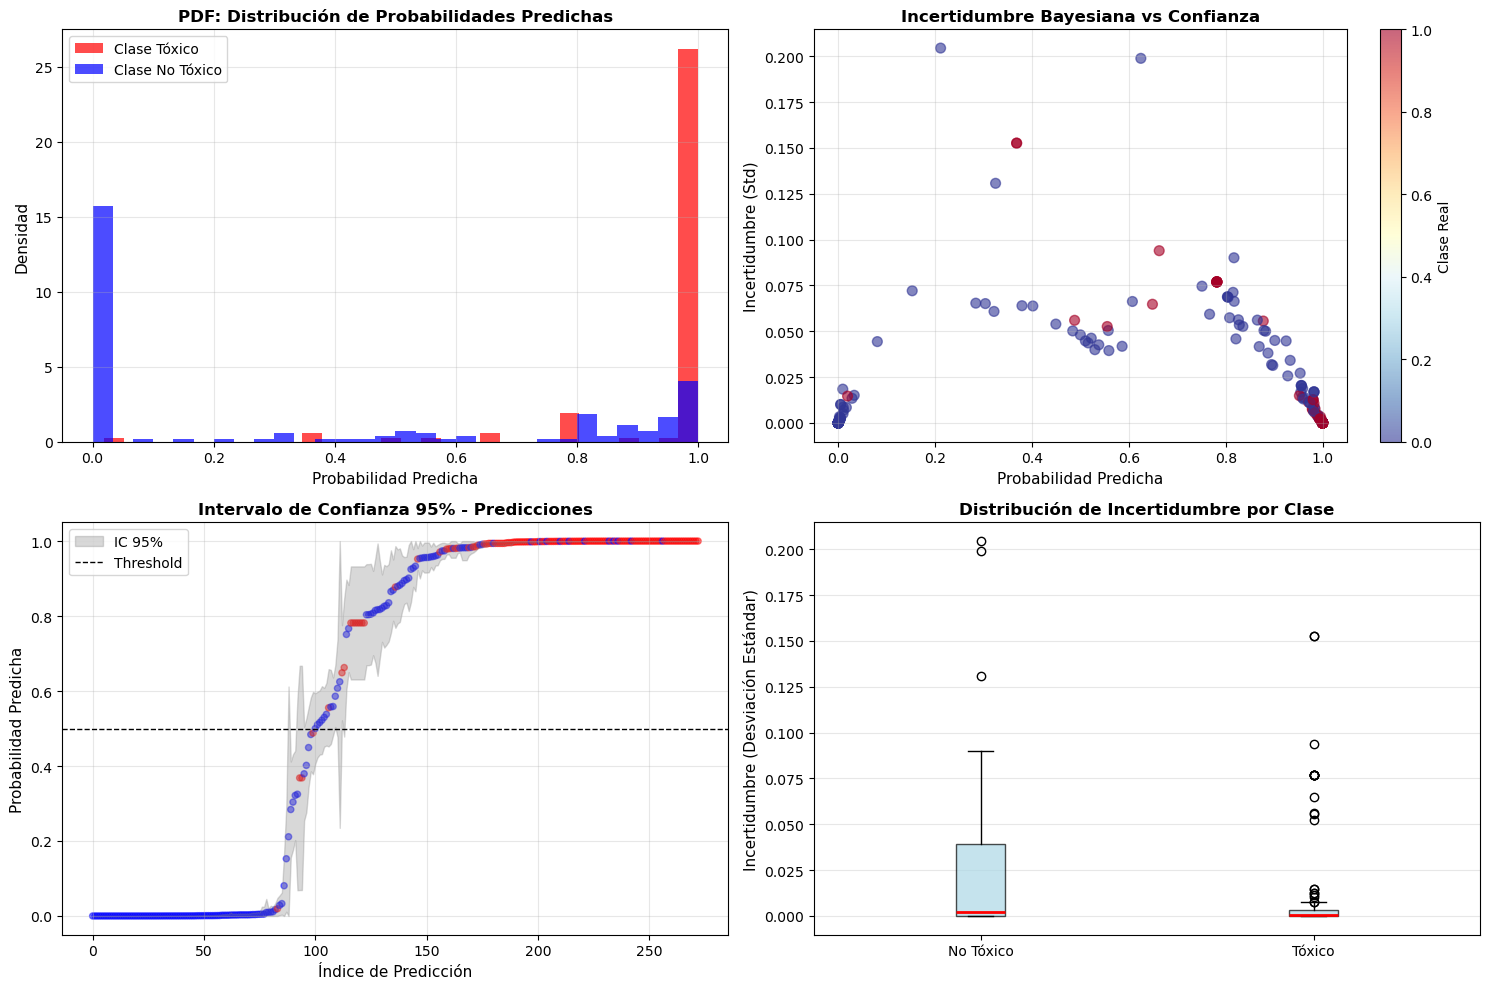

Incertidumbre media (No Tóxico): 0.0200
Incertidumbre media (Tóxico): 0.0120


In [24]:
# Visualizar Distribución de Predicciones e Incertidumbre
print("📊 Visualizando PDF de predicciones e incertidumbre...\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. PDF de predicciones para clase positiva
ax = axes[0, 0]
ax.hist(y_pred_mean[y_test_np == 1], bins=30, alpha=0.7, color='red', label='Clase Tóxico', density=True)
ax.hist(y_pred_mean[y_test_np == 0], bins=30, alpha=0.7, color='blue', label='Clase No Tóxico', density=True)
ax.set_xlabel('Probabilidad Predicha', fontsize=11)
ax.set_ylabel('Densidad', fontsize=11)
ax.set_title('PDF: Distribución de Probabilidades Predichas', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Incertidumbre vs Probabilidad
ax = axes[0, 1]
scatter = ax.scatter(y_pred_mean, y_pred_std, c=y_test_np, cmap='RdYlBu_r', alpha=0.6, s=50)
ax.set_xlabel('Probabilidad Predicha', fontsize=11)
ax.set_ylabel('Incertidumbre (Std)', fontsize=11)
ax.set_title('Incertidumbre Bayesiana vs Confianza', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Clase Real')

# 3. Intervalo de confianza (95%)
ax = axes[1, 0]
sorted_indices = np.argsort(y_pred_mean)
x_sorted = np.arange(len(sorted_indices))
y_sorted = y_pred_mean[sorted_indices]
ci_lower_sorted = y_pred_ci_lower[sorted_indices]
ci_upper_sorted = y_pred_ci_upper[sorted_indices]
y_true_sorted = y_test_np[sorted_indices]

colors = ['red' if y == 1 else 'blue' for y in y_true_sorted]
ax.scatter(x_sorted, y_sorted, c=colors, alpha=0.5, s=20)
ax.fill_between(x_sorted, ci_lower_sorted, ci_upper_sorted, alpha=0.3, color='gray', label='IC 95%')
ax.axhline(0.5, color='k', linestyle='--', linewidth=1, label='Threshold')
ax.set_xlabel('Índice de Predicción', fontsize=11)
ax.set_ylabel('Probabilidad Predicha', fontsize=11)
ax.set_title('Intervalo de Confianza 95% - Predicciones', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Distribución de incertidumbre por clase
ax = axes[1, 1]
ax.boxplot([y_pred_std[y_test_np == 0], y_pred_std[y_test_np == 1]], 
           labels=['No Tóxico', 'Tóxico'], patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax.set_ylabel('Incertidumbre (Desviación Estándar)', fontsize=11)
ax.set_title('Distribución de Incertidumbre por Clase', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Incertidumbre media (No Tóxico): {y_pred_std[y_test_np == 0].mean():.4f}")
print(f"Incertidumbre media (Tóxico): {y_pred_std[y_test_np == 1].mean():.4f}")


In [25]:
# Análisis de Curvas de Validación (Learning Curves)
print("📈 Generando curvas de validación (learning curves)...\n")

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Crear arrays para variar el tamaño del training set
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_mean = []
val_scores_mean = []
train_scores_std = []
val_scores_std = []

for train_size in train_sizes:
    train_indices = np.random.choice(len(X_train_tensor), int(train_size * len(X_train_tensor)), replace=False)
    
    # Re-entrenar con subconjunto
    pyro.clear_param_store()
    guide_subset = AutoDelta(model)
    optimizer_subset = Adam({"lr": 0.01})
    svi_subset = SVI(model, guide_subset, optimizer_subset, loss=Trace_ELBO())
    
    for epoch in range(50):
        X_subset = X_train_tensor[train_indices]
        y_subset = y_train_tensor[train_indices]
        
        for i in range(0, len(X_subset), 32):
            X_batch = X_subset[i:i+32]
            y_batch = y_subset[i:i+32]
            svi_subset.step(X_batch, y_batch)
    
    # Evaluar
    fc1_w = guide_subset.median()["fc1_w"]
    fc1_b = guide_subset.median()["fc1_b"]
    fc2_w = guide_subset.median()["fc2_w"]
    fc2_b = guide_subset.median()["fc2_b"]
    
    with torch.no_grad():
        # Training score
        h_train = torch.relu(torch.matmul(X_train_tensor[train_indices], fc1_w.t()) + fc1_b)
        pred_train = (torch.sigmoid(torch.matmul(h_train, fc2_w.t()) + fc2_b).squeeze(-1) >= 0.5).cpu().numpy()
        train_acc = accuracy_score(y_train_tensor[train_indices].cpu().numpy(), pred_train)
        
        # Validation score
        h_val = torch.relu(torch.matmul(X_test_tensor, fc1_w.t()) + fc1_b)
        pred_val = (torch.sigmoid(torch.matmul(h_val, fc2_w.t()) + fc2_b).squeeze(-1) >= 0.5).cpu().numpy()
        val_acc = accuracy_score(y_test_tensor.cpu().numpy(), pred_val)
    
    train_scores_mean.append(train_acc)
    val_scores_mean.append(val_acc)

print("✅ Curvas de validación calculadas")


📈 Generando curvas de validación (learning curves)...

✅ Curvas de validación calculadas


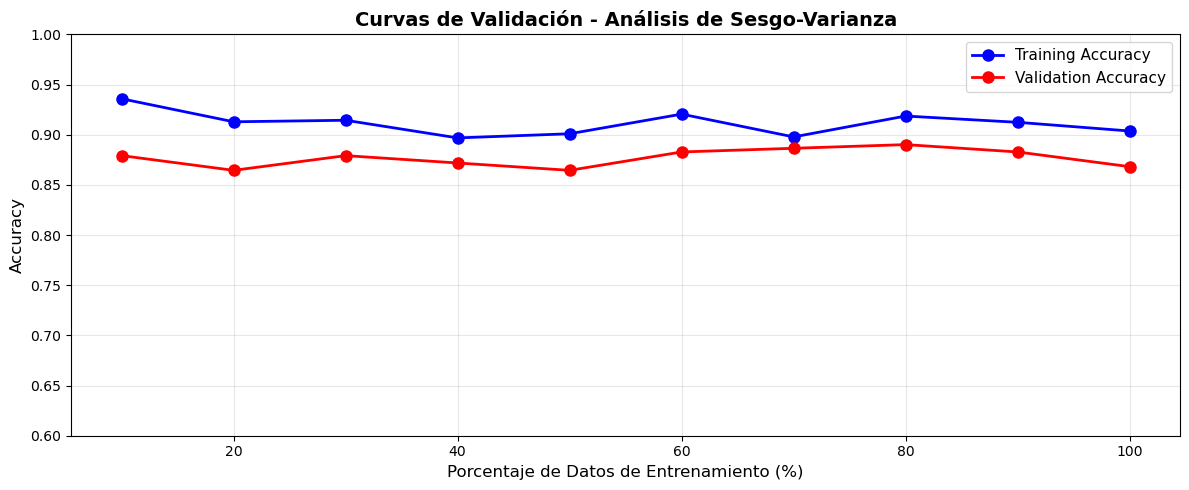

Training Accuracy Final: 0.9037
Validation Accuracy Final: 0.8681


In [26]:
# Graficar Learning Curves
plt.figure(figsize=(12, 5))

train_sizes_pct = train_sizes * 100
plt.plot(train_sizes_pct, train_scores_mean, 'o-', color='blue', linewidth=2, markersize=8, label='Training Accuracy')
plt.plot(train_sizes_pct, val_scores_mean, 'o-', color='red', linewidth=2, markersize=8, label='Validation Accuracy')

plt.xlabel('Porcentaje de Datos de Entrenamiento (%)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Curvas de Validación - Análisis de Sesgo-Varianza', fontsize=14, fontweight='bold')
plt.ylim([0.6, 1.0])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Training Accuracy Final: {train_scores_mean[-1]:.4f}")
print(f"Validation Accuracy Final: {val_scores_mean[-1]:.4f}")


🎯 Calculando importancia de características...

Importancia de Características (ordenadas):
dosage         : 1.0000
NOxygen        : 0.8673
e              : 0.5243
Expotime       : 0.4411
hydrosize      : 0.3649
surfarea       : 0.2522
surfcharge     : 0.1340
Ec             : 0.1263


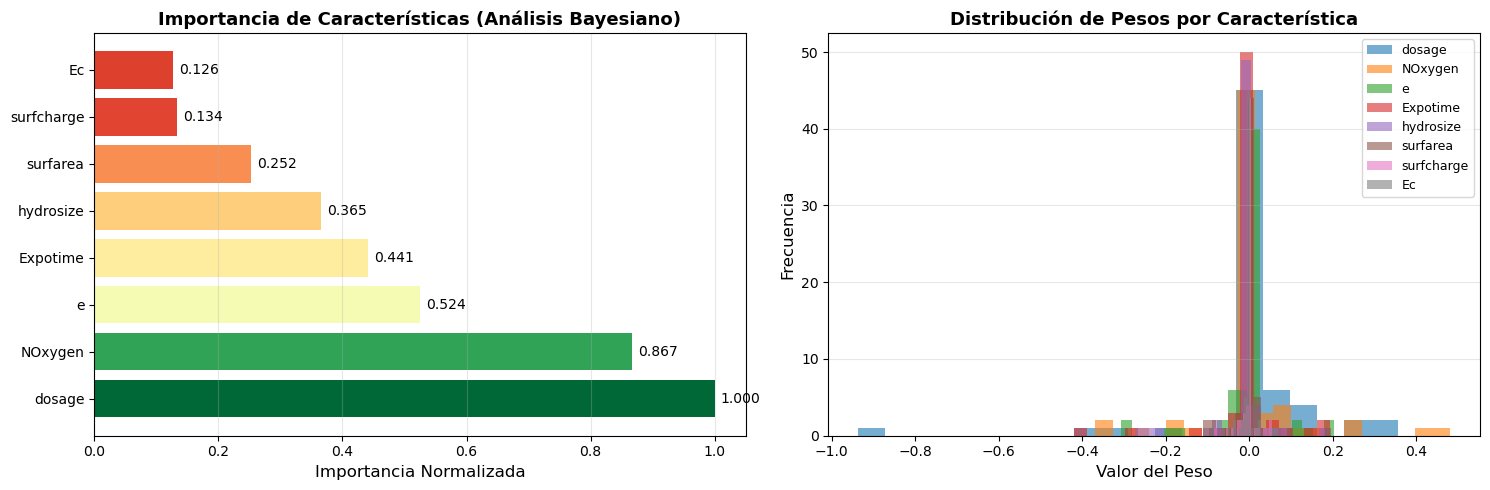


✅ Característica más importante: dosage
✅ Característica menos importante: Ec


In [27]:
# Importancia de Características (Feature Importance) - Análisis Bayesiano
print("🎯 Calculando importancia de características...\n")

# Obtener pesos de la primera capa
fc1_w_posterior = guide_auto.median()["fc1_w"]

# Importancia = promedio de valores absolutos de pesos (magnitud promedio)
feature_importance = torch.abs(fc1_w_posterior).mean(dim=0).cpu().numpy()

# Normalizar entre 0 y 1
feature_importance_norm = feature_importance / feature_importance.max()

# Nombres de características
feature_names = ['hydrosize', 'surfcharge', 'surfarea', 'Ec', 'Expotime', 'dosage', 'e', 'NOxygen']

# Ordenar por importancia
sorted_idx = np.argsort(feature_importance_norm)[::-1]

print("Importancia de Características (ordenadas):")
print("=" * 50)
for idx in sorted_idx:
    print(f"{feature_names[idx]:15s}: {feature_importance_norm[idx]:.4f}")

# Graficar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Barras ordenadas
ax = axes[0]
colors_importance = plt.cm.RdYlGn(feature_importance_norm[sorted_idx])
bars = ax.barh(np.array(feature_names)[sorted_idx], feature_importance_norm[sorted_idx], color=colors_importance)
ax.set_xlabel('Importancia Normalizada', fontsize=12)
ax.set_title('Importancia de Características (Análisis Bayesiano)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for i, (bar, val) in enumerate(zip(bars, feature_importance_norm[sorted_idx])):
    ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=10)

# Gráfico 2: Distribución de pesos por característica
ax = axes[1]
for idx in sorted_idx:
    ax.hist(fc1_w_posterior[:, idx].cpu().numpy(), bins=20, alpha=0.6, label=feature_names[idx])

ax.set_xlabel('Valor del Peso', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de Pesos por Característica', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✅ Característica más importante: {feature_names[sorted_idx[0]]}")
print(f"✅ Característica menos importante: {feature_names[sorted_idx[-1]]}")
